### Preparación del dataframe

In [2]:
# Librerías
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [3]:
df_ventas = pd.read_csv("df_ventas_3.csv", sep=",")

# Paso previo para crear var_objetivo
df_ventas["num_compras"] = 1

In [4]:
df_ventas.head()

,Unnamed: 0,item_id,num_order,created_at,product_id,qty_ordered,base_cost,price,discount_percent,customer_id,...,hour,week,day,margin_total,price_total,name,marca_value,analytic_category,nombre_corto,num_compras
0,0,000010d95384a6ba3d57dd870e7b337c,65717498f0771a49497d80f11160093c,2017-09-22 15:46:37,5645.0,1.0,7.4441,10.38,7.0,da5b59745c6a4699dee7684eba901bba,...,15,38,Friday,2.9359,10.38,Weleda Hombre Crema Hidratante 30 ml,weleda,cosmética y belleza,Weleda Hombre Crema Hidratante 30,1
1,1,00001a8fb0bd42b1e16ba731e30cc490,09b538e85ce396ecbb70695f91007830,2018-09-12 21:27:08,28743.0,2.0,35.3166,43.08,7.0,531a918355010bacbe506243a5f05c30,...,21,89,Wednesday,15.5268,86.16,Gynea Gestagyn Men 60 Capsulas,gynea,vida íntima,Gynea Gestagyn Men 60 Capsulas,1
2,2,0000302bc9b9a670dfcb14381555ff45,bc150db52b5a565d31b1c70969638ca9,2018-11-19 16:36:10,9999.0,1.0,2.4673,3.29,20.0,e63460a423099250ab43fe0acb370ff5,...,16,99,Monday,0.8227,3.29,Eladiet Fitotablet Castaño de Indias 60 Compri...,eladiet,NaN,Eladiet Fitotablet Castaño De Indias,1
3,3,000039147df4aacf0aa8b3a552e8ecdb,434cf1eaf255b367ce2d3343bb96b1fe,2017-09-06 12:08:44,68986.0,1.0,27.3680,33.88,5.0,14e6f6400d1c114d509844be3687cb19,...,12,36,Wednesday,6.5120,33.88,Endocare Tensage Ampollas 20uds x 2ml,endocare,cosmética y belleza,Endocare Tensage Ampollas 20Uds X,1
4,4,000091029a220c2fdf12700f07f70b1d,f268c24275ad1d887925fca2909e2c2d,2018-09-29 09:45:14,9692.0,1.0,3.1200,3.81,5.0,872bd419dfb24caf4f996a2cd2b8a9b4,...,9,91,Saturday,0.6900,3.81,Lacer Colutorio Fluor+Xilitol Sabor Fresa 500ml,lacer,higiene,Lacer Colutorio Fluor+Xilitol Sabor,1


In [5]:
# Se elimina la columna derivada del índice
df_ventas.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
#Añadir columnas a la lista que se quiera hacer dummies

columns_to_encoding = ['day', 'analytic_category']

for column in columns_to_encoding:
    dummies = pd.get_dummies(df_ventas[column])
    for dummy in dummies.columns:
        df_ventas[dummy] = dummies[dummy]
    df_ventas.drop(column, axis = 1, inplace=True)
df_ventas.columns

Index(['item_id', 'num_order', 'created_at', 'product_id', 'qty_ordered',
       'base_cost', 'price', 'discount_percent', 'customer_id', 'zipcode',
       'longitud_zip', 'country', 'region', 'city', 'date', 'year', 'hour',
       'week', 'margin_total', 'price_total', 'name', 'marca_value',
       'nombre_corto', 'num_compras', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'cosmética y belleza', 'herbolario',
       'higiene', 'infantil', 'nutrición', 'ortopedia', 'perfumeria',
       'veterinaria', 'vida íntima', 'óptica'],
      dtype='object')

In [7]:
# Diccionario con las funciones de agregación

dic_agg = {
    "price_total" : "sum",
    "qty_ordered": "sum",
    "discount_percent": "mean",
    "customer_id": "first",
    "city": "first",
    "num_compras":"first",
    'country': "first",
    'region': "first",
    'zipcode': "first",
    'hour': "first",
    }

dic_dummies = dict(zip(df_ventas.columns[list(range(24, len(df_ventas.columns)))].to_list(), ["max"] * (len(df_ventas.columns) - 24)))


dic_agg_2 = {
    "price_total" : "mean",
    "qty_ordered": "mean",
    "discount_percent": "mean",
    #"num_order": "size",
    "city": pd.Series.mode,
    'country': pd.Series.mode,
    'region': pd.Series.mode,
    'zipcode': pd.Series.mode,
    "num_compras": "sum",
    'hour': "mean"
    }

In [8]:
dic_agg.update(dic_dummies)
dic_agg_2.update(dic_dummies)

### GroupBy por pedidos

Paso previo requerido para poder hacer una correcta agrupación por cliente

In [9]:
# Groupby por pedidos


df_pedidos = df_ventas.groupby("num_order", as_index = False).agg(dic_agg)

### Agrupación por clientes

Obteniendo el dataframe final deseado

In [10]:
# Agrupación clientes
df_clientes = df_pedidos.groupby("customer_id").agg(dic_agg_2)

In [11]:
df_clientes.head()

,price_total,qty_ordered,discount_percent,city,country,region,zipcode,num_compras,hour,Friday,...,cosmética y belleza,herbolario,higiene,infantil,nutrición,ortopedia,perfumeria,veterinaria,vida íntima,óptica
customer_id,,,,,,,,,,,,,,,,,,,,,
000053b1e684c9e7ea73727b2238ce18,17.770,1.0,25.0,Torrelavega,Spain,Cantabria,39300,1,20.0,0,...,0,0,0,0,0,0,0,0,0,0
0001c82eb924a3dca30593bf7d8f2227,33.570,1.0,5.0,Leres De Jaca,Spain,Aragon,22714,1,19.0,0,...,1,0,0,0,0,0,0,0,0,0
0003883910709aa39bf38b05c51c03a3,82.560,6.0,7.0,Madrid,Spain,Madrid,28050,2,22.5,0,...,0,0,1,0,0,0,0,0,0,0
0003a36a46798bafcc69637f52f75e95,79.550,3.0,5.0,Barcelona,Spain,Cataluna,08020,1,21.0,0,...,1,0,0,0,0,0,0,0,0,0
0004a12374b272a1c591fd5122cde6a1,33.318,3.8,7.0,Aviles,Spain,Asturias,33403,5,15.6,1,...,1,1,1,1,0,0,0,0,1,1


### Obtención de variable objetivo y modelo a predecir

In [12]:
# Var_obj

df_clientes["num_compras"].replace(1, 0, inplace=True)
mascara_var_obj = df_clientes["num_compras"] > 1
df_clientes["num_compras"][mascara_var_obj] = 1

/tmp/ipykernel_288071/4007882791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clientes["num_compras"][mascara_var_obj] = 1


In [13]:
#Convertir categóricas restantes

list_col_cat = ["city", "country", "region", "zipcode"]

numeric_model = LabelEncoder()
for column in list_col_cat:
    list_values = list(df_clientes[column].unique())
    numeric_model.fit_transform(list_values)
    df_clientes[column] = numeric_model.transform(df_clientes[column])

Como uno de los objetivos es que porcentaje de probabilidad de repetir tienen los clientes, se utilizará el propio dataframe como si fuese un dataframe a predecir.

In [14]:
#df de predicción
df_clientes_no_target = df_clientes.drop("num_compras", axis = 1)

target = df_clientes["num_compras"]

In [15]:
# Imputación de valores perdidos

In [16]:
df_imputed = df_clientes_no_target
imputer = MissForest(criterion=('squared_error', 'gini'))

#Perform the imputation
df_imputed = imputer.fit_transform(df_imputed)

/workspaces/DatathonProject/venv/lib/python3.10/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


In [17]:
#List of columns with still NaN
columns_na = df_clientes_no_target.columns[df_clientes_no_target.isna().any()].tolist()
#Loop for replacing values of columns with NaN from the df imputed
for column in columns_na:
    index = df_clientes_no_target.columns.tolist().index(column)
    df_clientes_no_target[column] = df_imputed[:,index]
#Check there's no columns with NaN    
df_clientes_no_target.isnull().sum()

price_total            0
qty_ordered            0
discount_percent       0
city                   0
country                0
region                 0
zipcode                0
hour                   0
Friday                 0
Monday                 0
Saturday               0
Sunday                 0
Thursday               0
Tuesday                0
Wednesday              0
cosmética y belleza    0
herbolario             0
higiene                0
infantil               0
nutrición              0
ortopedia              0
perfumeria             0
veterinaria            0
vida íntima            0
óptica                 0
dtype: int64

### Modelo

In [20]:
# Librerias para el modelo

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


### Training-Test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_clientes_no_target, target, test_size = 0.2, random_state = 42, stratify = target)

### XGBoost

In [22]:
## Función para métricas

def saca_metricas(y1, y2):
    print('matriz de confusión')
    # print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

In [23]:
xgboost = XGBClassifier()

modelXGB = xgboost.fit(X_train, y_train,  eval_metric='rmse')

y_pred_XGB = modelXGB.predict(X_test)

print(classification_report(y_test, y_pred_XGB))



/workspaces/DatathonProject/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12700
           1       1.00      0.92      0.96     10860

    accuracy                           0.96     23560
   macro avg       0.97      0.96      0.96     23560
weighted avg       0.96      0.96      0.96     23560



matriz de confusión
accuracy
0.9602716468590832
precision
0.9984930681133213
recall
0.9151933701657459
f1
0.9550302680887864
AUC
0.9570061339017707


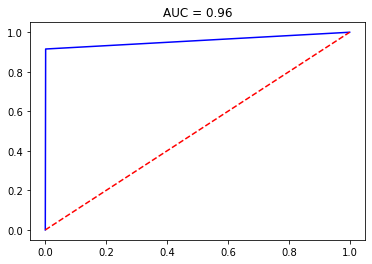

In [24]:
saca_metricas(y_test, y_pred_XGB)

### Variables con más influencia

In [25]:
# Variables

best_xgb_features = modelXGB.feature_importances_

best_xgb_features = pd.DataFrame(best_xgb_features,
                           index = X_train.columns,
                           columns=['importance']).sort_values('importance', ascending=False)

In [26]:
best_xgb_features

,importance
Sunday,0.123242
Monday,0.109119
Thursday,0.104810
Tuesday,0.104153
higiene,0.082865
Wednesday,0.082481
Friday,0.081803
Saturday,0.075944
cosmética y belleza,0.056750
qty_ordered,0.042281


In [27]:
mascara = best_xgb_features["importance"] > 0.01
best_features = best_xgb_features[mascara]
num_otras = 1 - best_features["importance"].sum()
nueva_fila = {"importance": num_otras}
best_features_otras = best_features
best_features_otras = best_features_otras.sort_values('importance', ascending=False)
best_features_otras = best_features_otras.append(nueva_fila, ignore_index=True)
best_index = best_features.index.tolist()
best_index.append("otras")
best_features_otras.index = best_index


/tmp/ipykernel_288071/2109732315.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_features_otras = best_features_otras.append(nueva_fila, ignore_index=True)


In [28]:
best_features_otras * 100
best_features * 100

,importance
Sunday,12.324236
Monday,10.911889
Thursday,10.481029
Tuesday,10.415273
higiene,8.286453
Wednesday,8.248102
Friday,8.180315
Saturday,7.594436
cosmética y belleza,5.675022
qty_ordered,4.228088


### Probabilidad de volver a comprar

In [29]:
clients_predict = modelXGB.predict_proba(df_clientes_no_target)
list_predict = []
for value in clients_predict:
    list_predict.append(value[1])

In [32]:
df_clientes_no_target["predict"] = list_predict
df_clientes_no_target["predict"] = df_clientes_no_target["predict"] * 100

df_pctge = pd.DataFrame(df_clientes_no_target["predict"])

df_pctge = df_pctge.sort_values('predict', ascending=False)

df_pctge.head()

,predict
customer_id,
e7a7135b3f6fd679d7b0f717f442e478,100.0
70c2f118940eb9d99c3bcc15f3a9f01c,100.0
94c32f9125a78db76c6002fb47973a70,100.0
ed8709d793531889b3912326d311d70e,100.0
94c71292ad0a8f8b2a18128cacda6650,100.0


In [33]:
# Intervalos 


list_var = ["0-20", "20-40", "40-60", "60-80", "80-100"]


df_pctge["predict_interval"] = df_pctge["predict"]


df_pctge["predict_interval"][df_pctge["predict"] <= 100] = "80-100"
df_pctge["predict_interval"][df_pctge["predict"] < 80] = "60-80"
df_pctge["predict_interval"][df_pctge["predict"] < 60] = "40-60"
df_pctge["predict_interval"][df_pctge["predict"] < 40] = "20-40"
df_pctge["predict_interval"][df_pctge["predict"] < 20] = "0-20"

**Exportación de resultados final**

In [34]:
# Porcentaje de clientes
df_pctge.to_excel("pctge_repetir_v2.xlsx")

# Porcentaje de importancia variables
best_features.to_excel("beast_features_v2.xlsx")

# Porcentaje de importancia variables agrupadas en otras las que menos importancia tienen
best_features_otras.to_excel("beast_features_otras_v2.xlsx")